In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Simulated data (line with noise in both x and y)
np.random.seed(0)
n = 50
true_slope = 2
true_intercept = 1
x = np.linspace(0, 10, n)
y = true_slope * x + true_intercept

# Add noise to both x and y
x_noisy = x + np.random.normal(scale=0.5, size=n)
y_noisy = y + np.random.normal(scale=0.5, size=n)


In [ ]:
# Stack into augmented matrix [X | y]
A = np.column_stack((x_noisy, np.ones(n), y_noisy))

# Perform SVD
U, S, Vt = np.linalg.svd(A, full_matrices=False)
v = Vt.T[:, -1]  # right singular vector corresponding to smallest singular value

In [2]:

# Extract TLS coefficients: v0*x + v1*1 = v2*y => y = -(v0/v2)*x - (v1/v2)
slope_tls = -v[0] / v[2]
intercept_tls = -v[1] / v[2]

Matplotlib created a temporary cache directory at /jobfs/139734659.gadi-pbs/matplotlib-_pfo913q because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


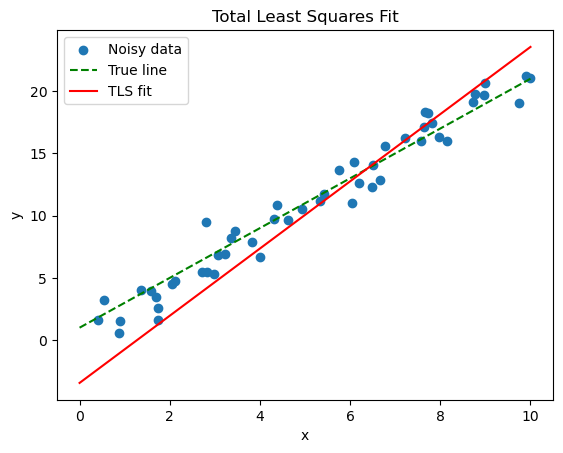

TLS slope: 2.699, intercept: -3.437


In [1]:
# Plotting
plt.scatter(x_noisy, y_noisy, label='Noisy data')
plt.plot(x, true_slope * x + true_intercept, 'g--', label='True line')
plt.plot(x, slope_tls * x + intercept_tls, 'r-', label='TLS fit')
plt.legend()
plt.title('Total Least Squares Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(f"TLS slope: {slope_tls:.3f}, intercept: {intercept_tls:.3f}")


# Maximum likelihood

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

# Set random seed for reproducibility
np.random.seed(42)


In [14]:
# Number of time steps (e.g., years) and number of forcings (e.g., GHG and AER)
n = 5
nf = 2

# Define true (unknown in real life) response to each forcing
# X1 = GHG, X2 = Aerosols (AER)
X1_star_true = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
X2_star_true = np.array([-0.1, -0.1, 0.0, 0.0, 0.1])

# Total true climate response is the sum of each forcing's true response
Y_star_true = X1_star_true + X2_star_true


In [15]:
# Observation noise (uncertainty in the real-world data)
Sigma_Y = np.eye(n) * 0.05  # small observational error

# Model error for each forcing (uncertainty in model simulations)
Sigma_X1 = np.eye(n) * 0.1  # GHG model error
Sigma_X2 = np.eye(n) * 0.1  # AER model error

# Generate noisy observations of total response
Y_obs = Y_star_true + np.random.multivariate_normal(np.zeros(n), Sigma_Y)

# Generate noisy model simulations for each forcing
X1_sim = X1_star_true + np.random.multivariate_normal(np.zeros(n), Sigma_X1)
X2_sim = X2_star_true + np.random.multivariate_normal(np.zeros(n), Sigma_X2)


In [16]:
# Stack the simulated model outputs into a single vector
X_sim = np.concatenate([X1_sim, X2_sim])  # Shape (2n,)

# Combine model uncertainties into a block-diagonal matrix
Sigma_X = block_diag(Sigma_X1, Sigma_X2)

# Matrix A maps the stacked vector [X1*, X2*] to their sum (Y*)
# Shape (n, 2n), since it stacks identity matrices side-by-side
A = np.hstack([np.eye(n), np.eye(n)])

# Invert the known covariance matrices
Sigma_Y_inv = np.linalg.inv(Sigma_Y)
Sigma_X_inv = np.linalg.inv(Sigma_X)

# Set up and solve the linear system:
# (Aᵀ Σ_Y⁻¹ A + Σ_X⁻¹) X* = Aᵀ Σ_Y⁻¹ Y + Σ_X⁻¹ X
lhs = A.T @ Sigma_Y_inv @ A + Sigma_X_inv
rhs = A.T @ Sigma_Y_inv @ Y_obs + Sigma_X_inv @ X_sim

# Solve for the best estimates of the true responses (stacked)
X_star_est = np.linalg.solve(lhs, rhs)

# Separate out the individual forcing estimates
X1_star_est = X_star_est[:n]
X2_star_est = X_star_est[n:]


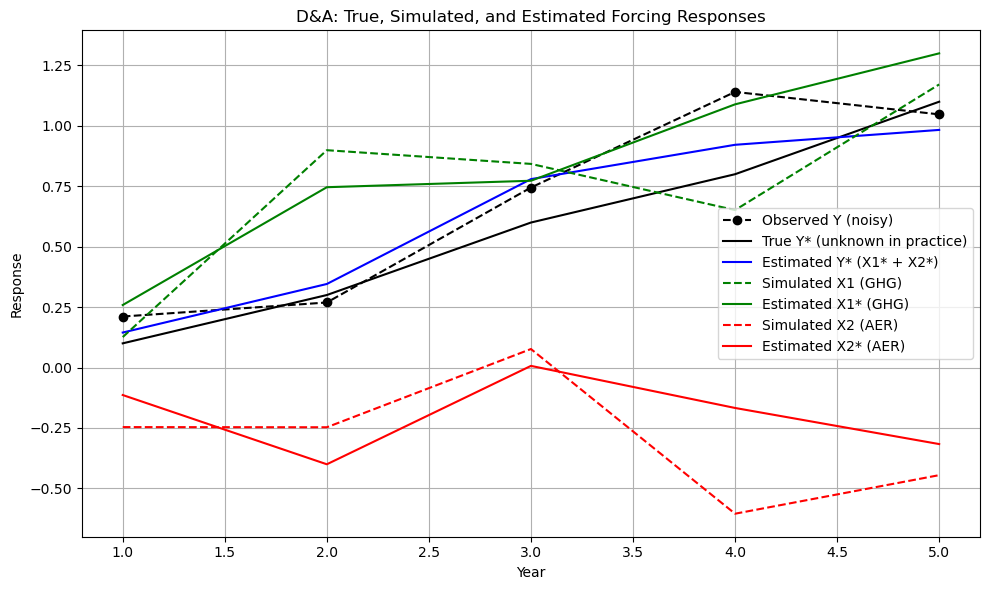

In [17]:
# Reconstruct total response from estimated components
Y_est = X1_star_est + X2_star_est
years = np.arange(1, n + 1)

# Plotting observed, simulated, and estimated responses
plt.figure(figsize=(10, 6))

plt.plot(years, Y_obs, 'ko--', label='Observed Y (noisy)')
plt.plot(years, Y_star_true, 'k-', label='True Y* (unknown in practice)')
plt.plot(years, Y_est, 'b-', label='Estimated Y* (X1* + X2*)')

# Forcing 1 (GHG)
plt.plot(years, X1_sim, 'g--', label='Simulated X1 (GHG)')
plt.plot(years, X1_star_est, 'g-', label='Estimated X1* (GHG)')

# Forcing 2 (AER)
plt.plot(years, X2_sim, 'r--', label='Simulated X2 (AER)')
plt.plot(years, X2_star_est, 'r-', label='Estimated X2* (AER)')

plt.xlabel('Year')
plt.ylabel('Response')
plt.title('D&A: True, Simulated, and Estimated Forcing Responses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


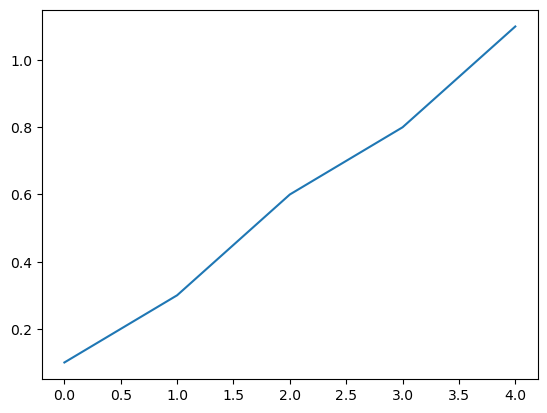

In [6]:
plt.plot(Y_star_true);